In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz, process
import re
import ftfy

# Data Loading

In [2]:
df1=pd.read_csv('dataset1.csv') # to read data set
df2=pd.read_csv('dataset2.csv')

In [3]:
df1.head()      # View first 5 rows

,Name,Short description,Gender,Occupation,Age of death
0,Vilém Pospíšil,Baptist minister,Male,Pastor,73.0
1,Elise Schmieden,schrijfster (1841-1896),NaN,Artist,55.0
2,Jerónimo de Rueda,Spanish baroque painter,Male,Artist,80.0
3,August Karl Wilhelm Weissenbruch,German author,Male,Artist,82.0
4,Gösta Göthlin,schwedischer Arzt und Bakteriologe,Male,Physician,89.0


# data set 1 Cleaning

In [4]:
df1.info()  # to view Data types and non-null values count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917131 entries, 0 to 917130
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Name               917131 non-null  object 
 1   Short description  866104 non-null  object 
 2   Gender             816763 non-null  object 
 3   Occupation         761744 non-null  object 
 4   Age of death       917130 non-null  float64
dtypes: float64(1), object(4)
memory usage: 35.0+ MB


In [5]:
def clean_name(name):
    try:  # Fix encoding issues
        # Step 1: Encode the string back to bytes using 'latin-1' (or 'Windows-1252')
        # Step 2: Decode the bytes using 'utf-8'
        name=name.encode('latin-1').decode('utf-8')
    except UnicodeError:
        name= name
    name = name.replace("''", "").replace('"', "").replace("'", "") # Normalize quotation marks and remove excessive ones
    name = re.sub(r"\s+", " ", name).strip()  # Remove leading/trailing spaces and multiple spaces
    # Normalize parentheses spacing (optional: remove them completely)
    name = re.sub(r"\(\s*", "(", name)  # Fix spacing around (
    name = re.sub(r"\s*\)", ")", name)  # Fix spacing around )

    name = name.lower()
    return name

In [6]:
names=df1["Name"] # Clean the names
cleaned_names = [clean_name(name) for name in names]
df1["Name"]=cleaned_names 

In [7]:
df1['Gender'] = df1['Gender'].fillna('Unknown').replace({0.0: 'Female', 1.0: 'Male'}) # fill nan values and gender consolidation
df1['Age of death'] = df1['Age of death'].fillna(0).astype(int)
df1['Short description'] = df1['Short description'].fillna('Unknown')
df1['Occupation'] = df1['Occupation'].fillna('Unknown')
df1.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917131 entries, 0 to 917130
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Name               917131 non-null  object
 1   Short description  917131 non-null  object
 2   Gender             917131 non-null  object
 3   Occupation         917131 non-null  object
 4   Age of death       917131 non-null  int32 
dtypes: int32(1), object(4)
memory usage: 31.5+ MB


In [8]:
df1.duplicated().sum()  # Count duplicate rows

39

In [9]:
df1.drop_duplicates(inplace=True)  # Remove duplicate rows

In [10]:
df1.describe() #Basic Statistics: The describe() function provides summary statistics for numerical columns.

,Age of death
count,917092.000000
mean,69.267216
std,16.629292
min,0.000000
25%,60.000000
50%,72.000000
75%,81.000000
max,169.000000


# address data set 1 outlier

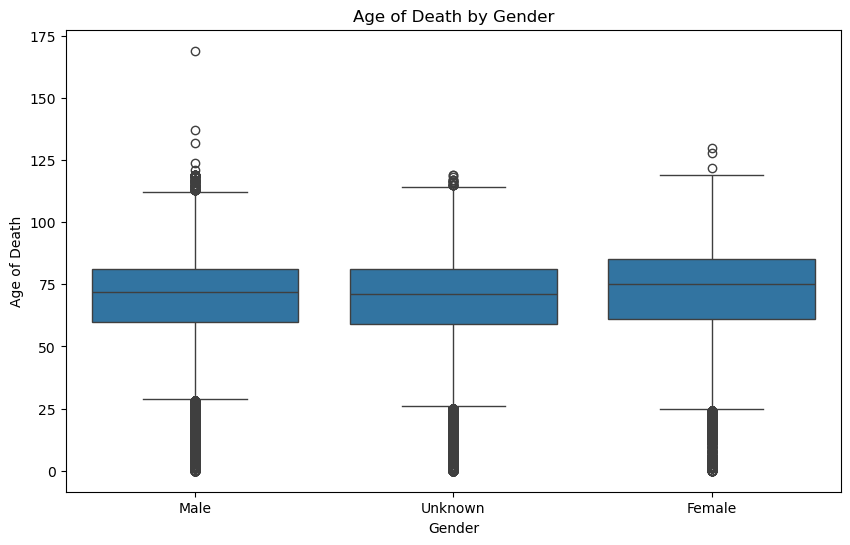

In [11]:
# Age of Death by Gender
plt.figure(figsize=(10, 6)) # to show extreme values that may be unreasonable
sns.boxplot(x='Gender', y='Age of death', data=df1)
plt.title('Age of Death by Gender')
plt.xlabel('Gender')
plt.ylabel('Age of Death')

plt.show()

In [12]:
age_seventy_fifth=df1['Age of death'].quantile(0.75) # Calculate the 75th percentile (third quartile, Q3)
age_twenty_fifth=df1['Age of death'].quantile(0.25) # Calculate the 25th percentile (first quartile, Q1)
age_iqr=age_seventy_fifth-age_twenty_fifth # Compute the Interquartile Range (IQR) as the difference between Q3 and Q1
upper=age_seventy_fifth+(1.5*age_iqr) # Calculate the upper bound for outlier detection (Q3 + 1.5 * IQR)
lower=age_twenty_fifth-(1.5*age_iqr) # Calculate the lower bound for outlier detection (Q1 - 1.5 * IQR)

#  data set 1 EDA

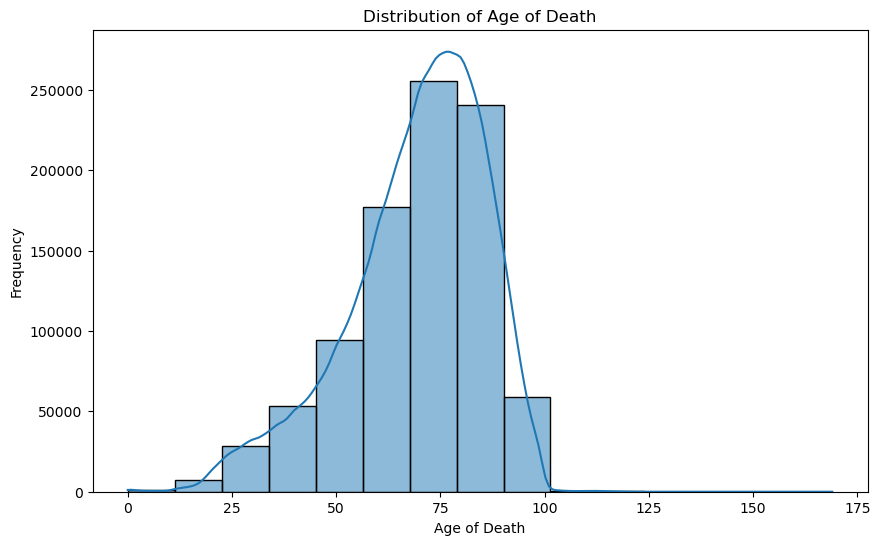

In [13]:
# Set the figure size for better visualization
plt.figure(figsize=(10, 6))

# Create a histogram with Kernel Density Estimate (KDE) overlay
# 'bins=15' specifies the number of bins in the histogram
sns.histplot(df1['Age of death'], kde=True, bins=15)
plt.title('Distribution of Age of Death') # Set the title of the plot
plt.xlabel('Age of Death') # Label the x-axis
plt.ylabel('Frequency') # Label the y-axis
plt.show() # Display the plot

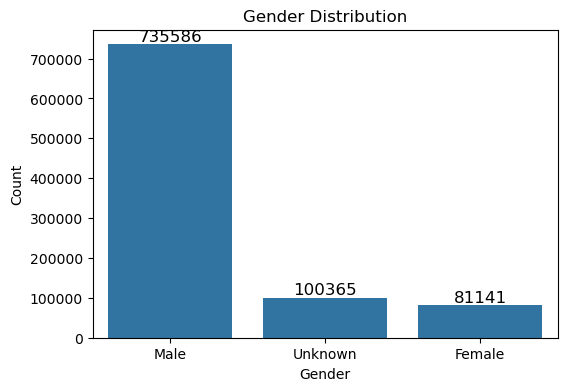

In [14]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Gender', data=df1)

# Add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,  # X position
            p.get_height() + 1000,  # Y position (slightly above the bar)
            int(p.get_height()),  # The count value
            ha='center', va='bottom', fontsize=12, color='black')  # Styling

plt.title('Gender Distribution') # Set the title of the plot
plt.xlabel('Gender') # Label the x-axis
plt.ylabel('Count') # Label the y-axis
plt.show() # Display the plot

In [15]:
avg_age_by_occupation = df1.groupby('Occupation')['Age of death'].mean().sort_values(ascending=False) # Calculate average age of death by occupation
print("\nAverage Age of Death by Occupation:")
print(avg_age_by_occupation)


Average Age of Death by Occupation:
Occupation
Farmer; lecturer                                            121.0
Suffragette; philanthropist; social reformer; suffragist     99.0
Film producer; publicist                                     99.0
Astronomer; inventor                                         99.0
Tarento; critic                                              99.0
                                                            ...  
Basij                                                        13.0
Lehnsmann                                                    13.0
Servant of god                                               12.0
Pioneers-heroes                                              11.0
Miner; master builder                                        11.0
Name: Age of death, Length: 7735, dtype: float64


In [16]:
avg_age_by_gender = df1.groupby('Gender')['Age of death'].mean().sort_values(ascending=False) # Calculate average age of death by gender
print("\nAverage Age of Death by Gender:")
print(avg_age_by_gender)


Average Age of Death by Gender:
Gender
Female     71.216894
Male       69.189895
Unknown    68.257679
Name: Age of death, dtype: float64


# remove dataset1 outlier

In [17]:
df1=df1[(df1["Age of death"]>lower) & (df1["Age of death"]<upper)]

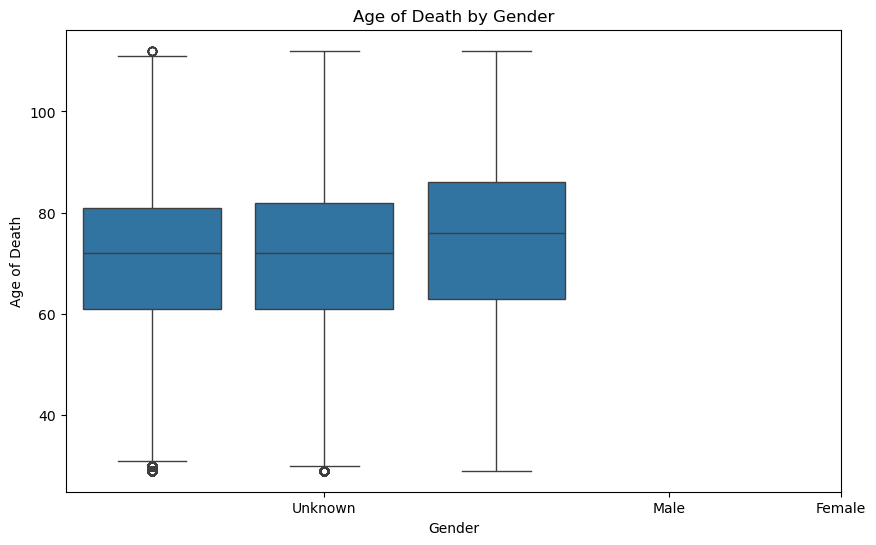

In [18]:
# Age of Death by Gender
plt.figure(figsize=(10, 6)) # to show extreme values that may be unreasonable
sns.boxplot(x='Gender', y='Age of death', data=df1)
plt.title('Age of Death by Gender')
plt.xlabel('Gender')
plt.ylabel('Age of Death')
plt.xticks(ticks=['M','Unknown','F'],labels=['Male','Unknown','Female'])
plt.show()

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 895028 entries, 0 to 917130
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Name               895028 non-null  object
 1   Short description  895028 non-null  object
 2   Gender             895028 non-null  object
 3   Occupation         895028 non-null  object
 4   Age of death       895028 non-null  int32 
dtypes: int32(1), object(4)
memory usage: 37.6+ MB


In [20]:
df1.describe()

,Age of death
count,895028.000000
mean,70.396194
std,15.093432
min,29.000000
25%,61.000000
50%,72.000000
75%,82.000000
max,112.000000


#  data set 2 cleaning

In [21]:
df2.head() 

,Name,Gender,Country,Birth year,Death year,Manner of death
0,Yin Buhai,NaN,Chen dynasty,505,589.0,NaN
1,Johann von Wickede,1.0,NaN,1664,1732.0,NaN
2,Frank McCashney,1.0,Australia,1890,1951.0,NaN
3,Hugo Berwald,1.0,Germany,1863,1937.0,NaN
4,Karel Fiala,1.0,Czechoslovakia,1871,1931.0,NaN


In [22]:
df2.info() # to show null values and data types 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855989 entries, 0 to 855988
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             855989 non-null  object 
 1   Gender           762276 non-null  float64
 2   Country          621522 non-null  object 
 3   Birth year       855989 non-null  int64  
 4   Death year       855989 non-null  float64
 5   Manner of death  37566 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 39.2+ MB


In [23]:
names=df2["Name"]
cleaned_names = [clean_name(name) for name in names]  # Clean the names
df2["Name"]=cleaned_names 
df2['Gender'] = df2['Gender'].replace({2.0: 'Female', 1.0: 'Male'}) # gender consolidation
df2["Gender"] = df2["Gender"].fillna('Unknown') # fill nan values and
df2["Death year"] = df2["Death year"].astype(int) 
df2['Country'] = df2['Country'].fillna('Unknown')
df2['Manner of death'] = df2['Manner of death'].fillna('Unknown')
df2['Age of death'] = df2['Death year']-df2['Birth year'] # new calculated column for matching datasets
df2.info() # to check null values and dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855989 entries, 0 to 855988
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Name             855989 non-null  object
 1   Gender           855989 non-null  object
 2   Country          855989 non-null  object
 3   Birth year       855989 non-null  int64 
 4   Death year       855989 non-null  int32 
 5   Manner of death  855989 non-null  object
 6   Age of death     855989 non-null  int64 
dtypes: int32(1), int64(2), object(4)
memory usage: 42.4+ MB


In [24]:
df2.duplicated().sum() # to count duplicates
 

121

In [25]:
df2.drop_duplicates(inplace=True) # to drop duplicates

In [26]:
df2.describe()  #Basic Statistics: The describe() function provides summary statistics for numerical columns.

,Birth year,Death year,Age of death
count,855868.000000,855868.000000,855868.000000
mean,1845.019704,1914.299932,69.280228
std,147.987731,151.735286,16.636472
min,-2284.000000,-2200.000000,0.000000
25%,1828.000000,1895.000000,60.000000
50%,1887.000000,1955.000000,72.000000
75%,1918.000000,1994.000000,82.000000
max,2016.000000,2021.000000,169.000000


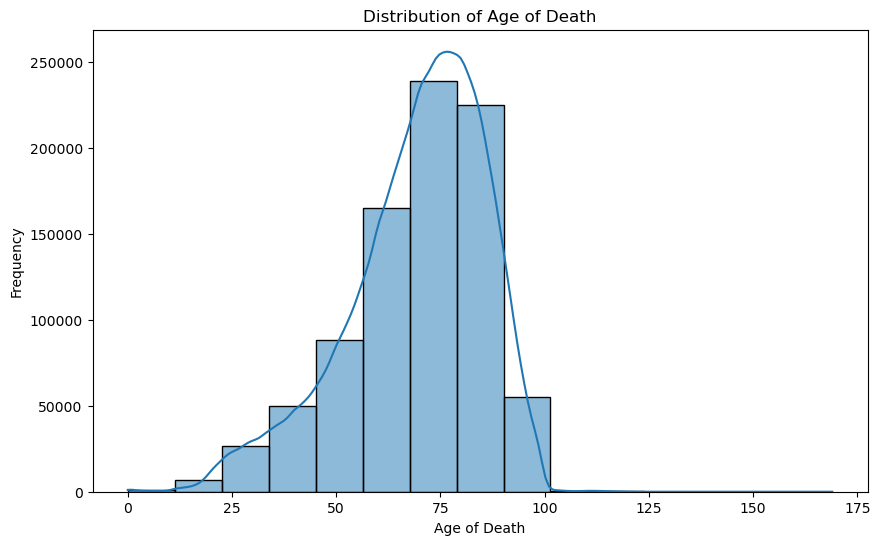

In [27]:
# Set the figure size for better visualization
plt.figure(figsize=(10, 6))

# Create a histogram with Kernel Density Estimate (KDE) overlay
# 'bins=15' specifies the number of bins in the histogram
sns.histplot(df2['Age of death'], kde=True, bins=15)
plt.title('Distribution of Age of Death') # Set the title of the plot
plt.xlabel('Age of Death') # Label the x-axis
plt.ylabel('Frequency') # Label the y-axis
plt.show() # Display the plot

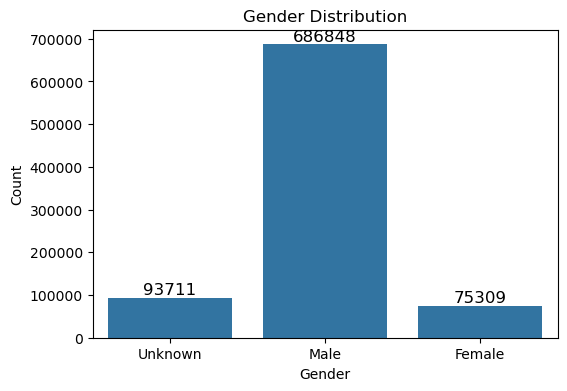

In [28]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Gender', data=df2)

# Add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,  # X position
            p.get_height() + 1000,  # Y position (slightly above the bar)
            int(p.get_height()),  # The count value
            ha='center', va='bottom', fontsize=12, color='black')  # Styling

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [29]:
# Country Distribution
df2["Country"].value_counts()

Country
Unknown                     234371
United States of America    109995
Germany                      69020
France                       56210
United Kingdom               37342
                             ...  
Frances                          1
American Samoa                   1
Slovaks                          1
Taifa of Zaragoza                1
Brandenburg-Prussia              1
Name: count, Length: 972, dtype: int64

In [30]:
df2["Manner of death"].value_counts()

Manner of death
Unknown                  818302
natural causes            23493
suicide                    4121
accident                   3549
homicide                   3253
                          ...  
scarlet fever                 1
lethal injection              1
death by misadventure         1
stomach cancer                1
tram accident                 1
Name: count, Length: 143, dtype: int64

# detect data set 2 outlier

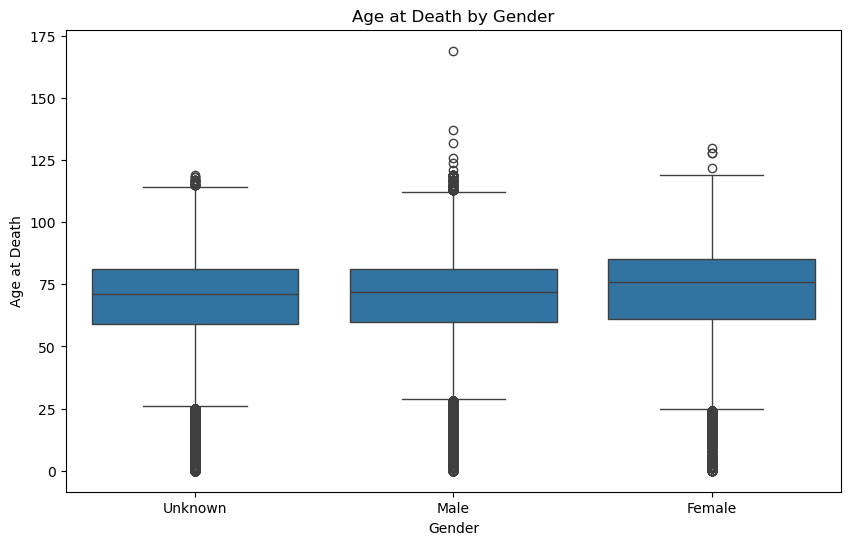

In [31]:
# Age at Death by Gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Age of death', data=df2)
plt.title('Age at Death by Gender')
plt.xlabel('Gender')
plt.ylabel('Age at Death')
plt.show()

In [32]:
age_seventy_fifth=df2['Age of death'].quantile(0.75) # Calculate the 75th percentile (third quartile, Q3)
age_twenty_fifth=df2['Age of death'].quantile(0.25) # Calculate the 25th percentile (first quartile, Q1)
age_iqr=age_seventy_fifth-age_twenty_fifth # Compute the Interquartile Range (IQR) as the difference between Q3 and Q1
upper=age_seventy_fifth+(1.5*age_iqr) # Calculate the upper bound for outlier detection (Q3 + 1.5 * IQR)
lower=age_twenty_fifth-(1.5*age_iqr) # Calculate the lower bound for outlier detection (Q1 - 1.5 * IQR)

# Data set 2 EDA

In [33]:
# Calculate average age at death by country
avg_age_by_country = df2.groupby('Country')['Age of death'].mean().sort_values(ascending=False)
print("\nAverage Age at Death by Country:")
print(avg_age_by_country)


Average Age at Death by Country:
Country
Francesa                      99.0
Shang dynasty                 99.0
Ho Chi Minh City              97.0
Kingdom of Rheged             94.0
fictional extraterrestrial    94.0
                              ... 
Great Moravia                 19.0
North Sea Empire              18.0
Rouen                         17.0
Banu Qasi                     15.0
Cheng Han                     11.0
Name: Age of death, Length: 972, dtype: float64


In [34]:
# Calculate average age at death by gender
avg_age_by_gender = df2.groupby('Gender')['Age of death'].mean().sort_values(ascending=False)
print("\nAverage Age at Death by Gender:")
print(avg_age_by_gender)


Average Age at Death by Gender:
Gender
Female     71.314982
Male       69.189946
Unknown    68.306752
Name: Age of death, dtype: float64


In [35]:
# Manner of death analysis
print("\nManner of Death Analysis:")
print(df2['Manner of death'].value_counts())


Manner of Death Analysis:
Manner of death
Unknown                  818302
natural causes            23493
suicide                    4121
accident                   3549
homicide                   3253
                          ...  
scarlet fever                 1
lethal injection              1
death by misadventure         1
stomach cancer                1
tram accident                 1
Name: count, Length: 143, dtype: int64


# remove outlier data set 2

In [36]:
df2=df2[(df2["Age of death"]>lower) & (df2["Age of death"]<upper)]

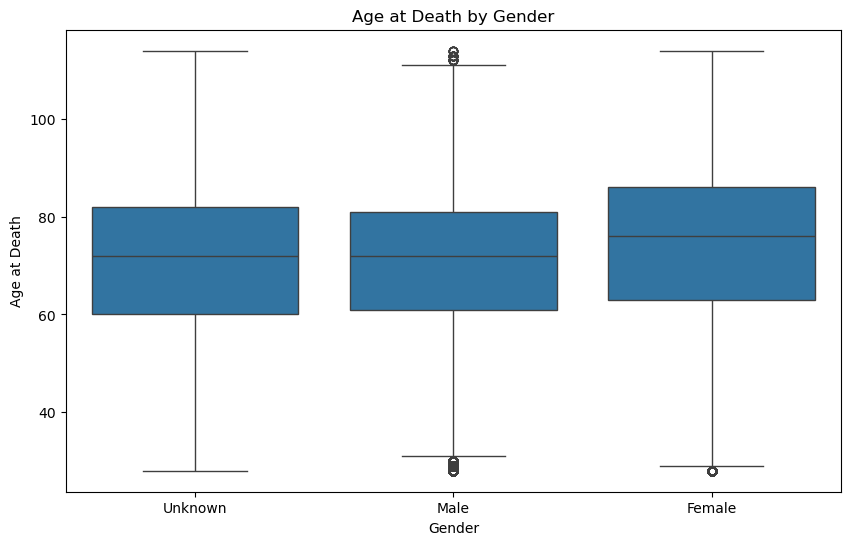

In [37]:
# Age at Death by Gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Age of death', data=df2)
plt.title('Age at Death by Gender')
plt.xlabel('Gender')
plt.ylabel('Age at Death')
plt.show()

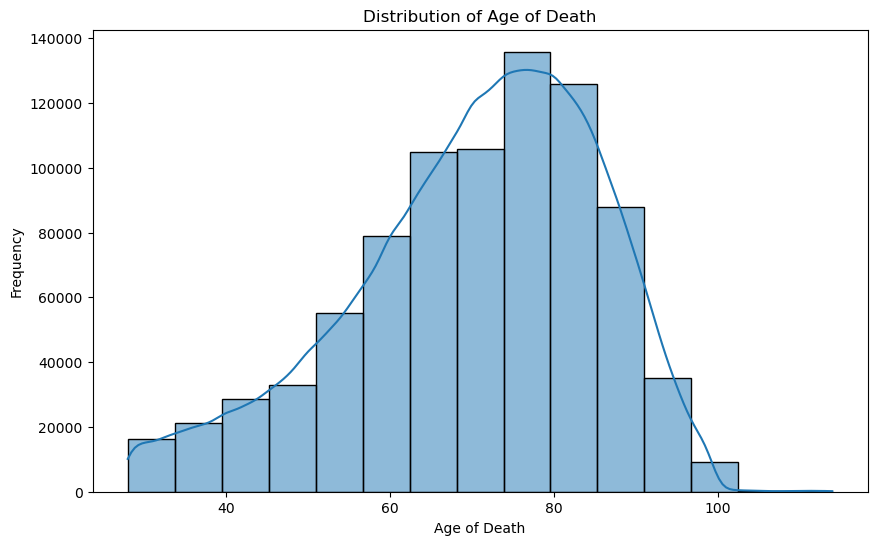

In [38]:
# Set the figure size for better visualization
plt.figure(figsize=(10, 6))

# Create a histogram with Kernel Density Estimate (KDE) overlay
# 'bins=15' specifies the number of bins in the histogram
sns.histplot(df2['Age of death'], kde=True, bins=15)
plt.title('Distribution of Age of Death') # Set the title of the plot
plt.xlabel('Age of Death') # Label the x-axis
plt.ylabel('Frequency') # Label the y-axis
plt.show() # Display the plot


# fuzzy match

In [39]:
# df1["Name"] = df1["Name"].apply(lambda x: process.extractOne(x, df2["Name"], scorer=fuzz.partial_ratio)[0])
# # Attempt to join the two dataframe
# data = pd.merge(df1, df2, on=["Name","Age of death"], how="left")
# print(data.head())

# merge data sets

In [40]:
merged = pd.merge(df1, df2, on=['Name',"Age of death",'Gender'], how='outer')

In [41]:
merged.head()

,Name,Short description,Gender,Occupation,Age of death,Country,Birth year,Death year,Manner of death
0,(hermano) daniel,botanist (1909-1988),Male,Researcher,79,Unknown,1909.0,1988.0,Unknown
1,(héctor) enrique correa labra,Chilean judge,Male,Judge,89,NaN,NaN,NaN,NaN
2,(jean pierre) adrien warion,botanist (1837-1880),Male,Researcher,43,NaN,NaN,NaN,NaN
3,(kathleen) rachel maxwell- hyslop,NaN,Female,NaN,97,Unknown,1914.0,2011.0,Unknown
4,(lawrence) george wheeler,1914-2006 Spanish civil war veteran,Male,Veteran; author,92,Unknown,1914.0,2006.0,Unknown


In [42]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109002 entries, 0 to 1109001
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Name               1109002 non-null  object 
 1   Short description  898972 non-null   object 
 2   Gender             1109002 non-null  object 
 3   Occupation         898972 non-null   object 
 4   Age of death       1109002 non-null  int64  
 5   Country            842128 non-null   object 
 6   Birth year         842128 non-null   float64
 7   Death year         842128 non-null   float64
 8   Manner of death    842128 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 76.1+ MB


# clean merged data 

In [43]:
merged["Birth year"]=merged["Birth year"].fillna(0)
merged["Death year"]=merged["Death year"].fillna(0)
merged["Short description"]=merged["Short description"].fillna('Unknown')
merged["Country"]=merged["Country"].fillna('Unknown')
merged["Manner of death"]=merged["Manner of death"].fillna('Unknown')
merged["Occupation"]=merged["Occupation"].fillna('Unknown')
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109002 entries, 0 to 1109001
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Name               1109002 non-null  object 
 1   Short description  1109002 non-null  object 
 2   Gender             1109002 non-null  object 
 3   Occupation         1109002 non-null  object 
 4   Age of death       1109002 non-null  int64  
 5   Country            1109002 non-null  object 
 6   Birth year         1109002 non-null  float64
 7   Death year         1109002 non-null  float64
 8   Manner of death    1109002 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 76.1+ MB


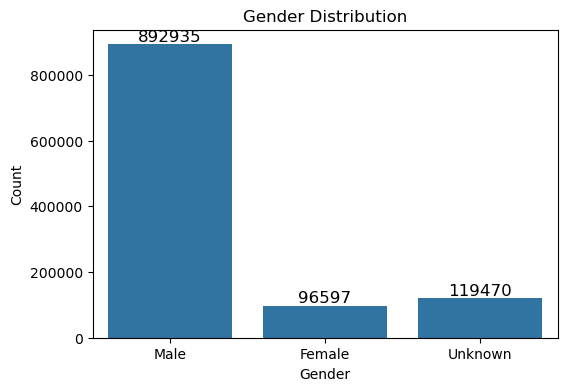

In [44]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Gender', data=merged)

# Add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,  # X position
            p.get_height() + 1000,  # Y position (slightly above the bar)
            int(p.get_height()),  # The count value
            ha='center', va='bottom', fontsize=12, color='black')  # Styling

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [45]:
# Calculate average age at death by country
avg_age_by_country = merged.groupby('Country')['Age of death'].mean().sort_values(ascending=False)
print("\nAverage Age at Death by Country:")
print(avg_age_by_country)


Average Age at Death by Country:
Country
Shang dynasty                    99.0
Francesa                         99.0
Ho Chi Minh City                 97.0
Kingdom of Rheged                94.0
fictional extraterrestrial       94.0
                                 ... 
Buganda                          30.0
Swabia                           30.0
County of Apulia and Calabria    30.0
Principality of Beloozero        30.0
Catalan                          28.0
Name: Age of death, Length: 950, dtype: float64


In [46]:
country_counts =  merged['Country'].value_counts() # Count occurrences of each country
print(country_counts.head(10))# Display the top 10 most represented countries

Country
Unknown                     495789
United States of America    108847
Germany                      68423
France                       55393
United Kingdom               37464
Sweden                       18936
Spain                        18536
Canada                       16338
Italy                        15450
Poland                       14508
Name: count, dtype: int64


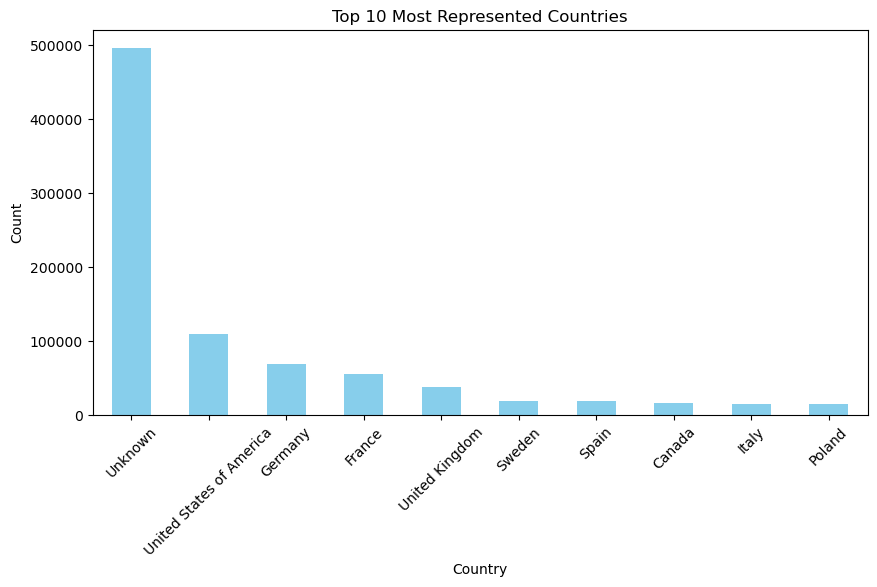

In [47]:
# Display the top 10 most represented countries
country_counts.head(10).plot(kind='bar', figsize=(10,5), color='skyblue')
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Top 10 Most Represented Countries")
plt.xticks(rotation=45)
plt.show()

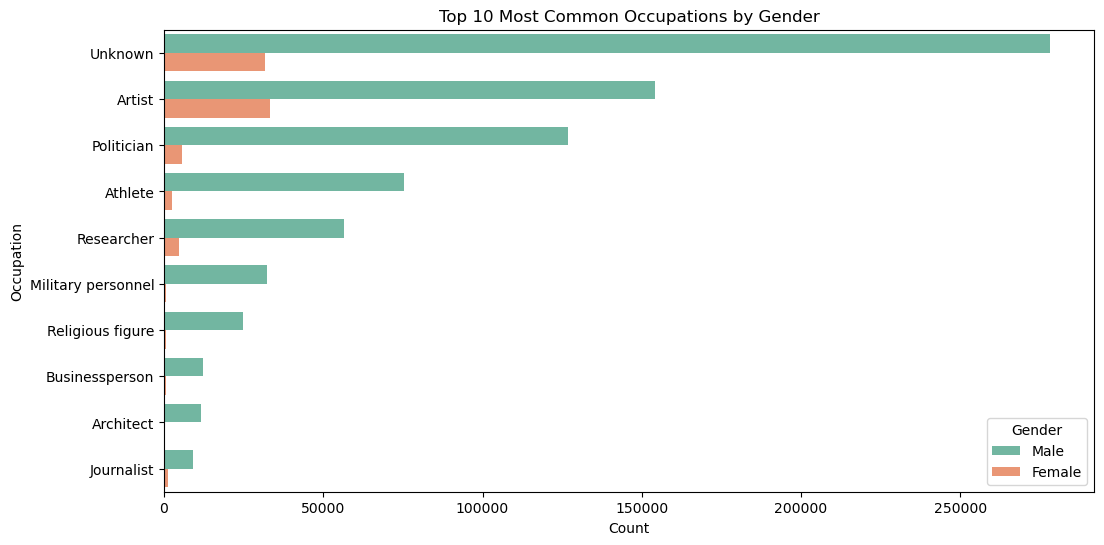

In [60]:
# Get the top 10 most common occupations
top_occupations_list = merged['Occupation'].value_counts().head(10).index

# Filter dataset for only these occupations
filtered_df = merged[merged["Occupation"].isin(top_occupations_list)]

# Plot the data
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, y="Occupation", hue="Gender", order=top_occupations_list, palette="Set2")

plt.xlabel("Count")
plt.ylabel("Occupation")
plt.title("Top 10 Most Common Occupations by Gender")
plt.legend(title="Gender")
plt.show()


In [50]:
merged['Age of death'].mean()

70.30995255193407

In [51]:
merged.groupby('Country')['Age of death'].mean()

Country
Abbasid Caliphate     70.220930
Abbasids              58.000000
Achaemenid Empire     66.000000
Afghan                57.000000
Afghanistan           63.343284
                        ...    
historical country    59.500000
history of Genoa      50.000000
island nation         79.500000
nationality           89.000000
statelessness         73.000000
Name: Age of death, Length: 950, dtype: float64

In [53]:
merged.groupby('Gender')['Age of death'].mean()

Gender
Female     72.905059
Male       70.077497
Unknown    69.949092
Name: Age of death, dtype: float64

In [52]:
unknown_count_country= (merged['Country']== "Unknown").sum()
print(f"Number of null values in 'Country': {unknown_count_country}")
unknown_count_death_manner= (merged['Manner of death']== "Unknown").sum()
print(f"Number of null values in 'Manner of death': {unknown_count_death_manner}")
unknown_count_gender= (merged['Gender']== "Unknown").sum()
print(f"Number of null values in 'gender': {unknown_count_gender}")

Number of null values in 'Country': 495789
Number of null values in 'Manner of death': 1073697
Number of null values in 'gender': 119470


# Handling Missing gender 
#### Use Forward/Backward Fill (if data is sequential) by name if the gender was known 
# Handling Missing manner of death 
#### this column has many nan value we may drop it or filter data , that value  is exist 
# Handling Missing country 
#### Replace with "Unknown" or "Other"

In [54]:
merged.to_csv('output1.csv', index=False)

# Handling Missing Gender Using Forward/Backward Fill

In [55]:
# Replace "Unknown" with None (NaN)
merged['Gender'] = merged['Gender'].replace("Unknown", None)

# Forward fill missing values
merged['Gender'] = merged.groupby('Name')['Gender'].ffill()

print("\nAfter filling missing gender values:")
print(merged["Gender"].value_counts())



After filling missing gender values:
Gender
Male      896386
Female     96805
Name: count, dtype: int64
